**A lot of this stuff is kind of a "while we're here, why not check out some cool questions regarding differences between the two coasts on a more meta-level than the actual modelling is carried out on.**

**A lot of these metrics, as much as they are maybe of interest for a genuine exploration of rap lyrics, are useful more than anything for finding the dodgy song entries. Think of other metrics for this.**

**TBH, because the dataset is small, you can probs scroll through pretty quickly and find the dodgy entries.**

In [101]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from operator import itemgetter

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import random

*Actual EDA:*

In [53]:
len(whole_frame[whole_frame.coast == 'east']), len(whole_frame[whole_frame.coast == 'west'])

(1511, 1179)

In [12]:
whole_frame = pd.read_csv('whole_frame.csv', index_col='Unnamed: 0')

In [13]:
whole_frame.head()

,artist,lyrics,coast
0,Cappadonna,well now you always seemed so brave before wha...,east
1,Cappadonna,red dog ebonies half gotti and lebanese you se...,east
2,Cappadonna,where you going arent you scared well get you ...,east
3,Cappadonna,yo break that dutch down you and your man yall...,east
4,Cappadonna,repeating in background rock the body body ro...,east


In [14]:
# can see the moderate class imbalance here
whole_frame.coast.value_counts(normalize=True)

east    0.56171
west    0.43829
Name: coast, dtype: float64

In [17]:
# finding the number of tracks for each artist
artist_eda = whole_frame.groupby(['coast', 'artist'], as_index=False).count()
artist_eda.head()

,coast,artist,lyrics
0,east,A Tribe Called Quest,67
1,east,AZ,22
2,east,Bahamadia,10
3,east,Big Daddy Kane,82
4,east,Big L,10


In [19]:
# separating this dataframe into two: one for each coast
west_eda = artist_eda[artist_eda['coast'] == 'west'].sort_values('lyrics')
east_eda = artist_eda[artist_eda['coast'] == 'east'].sort_values('lyrics')

In [20]:
len(west_eda), len(east_eda)
# Fairly sizeable imbalance in the number of artists for each coast in the dataset. 

(37, 48)

**Inspecting the distribution of the data**

***BY ARTIST***

Number of songs for each artist, looking at both coasts:

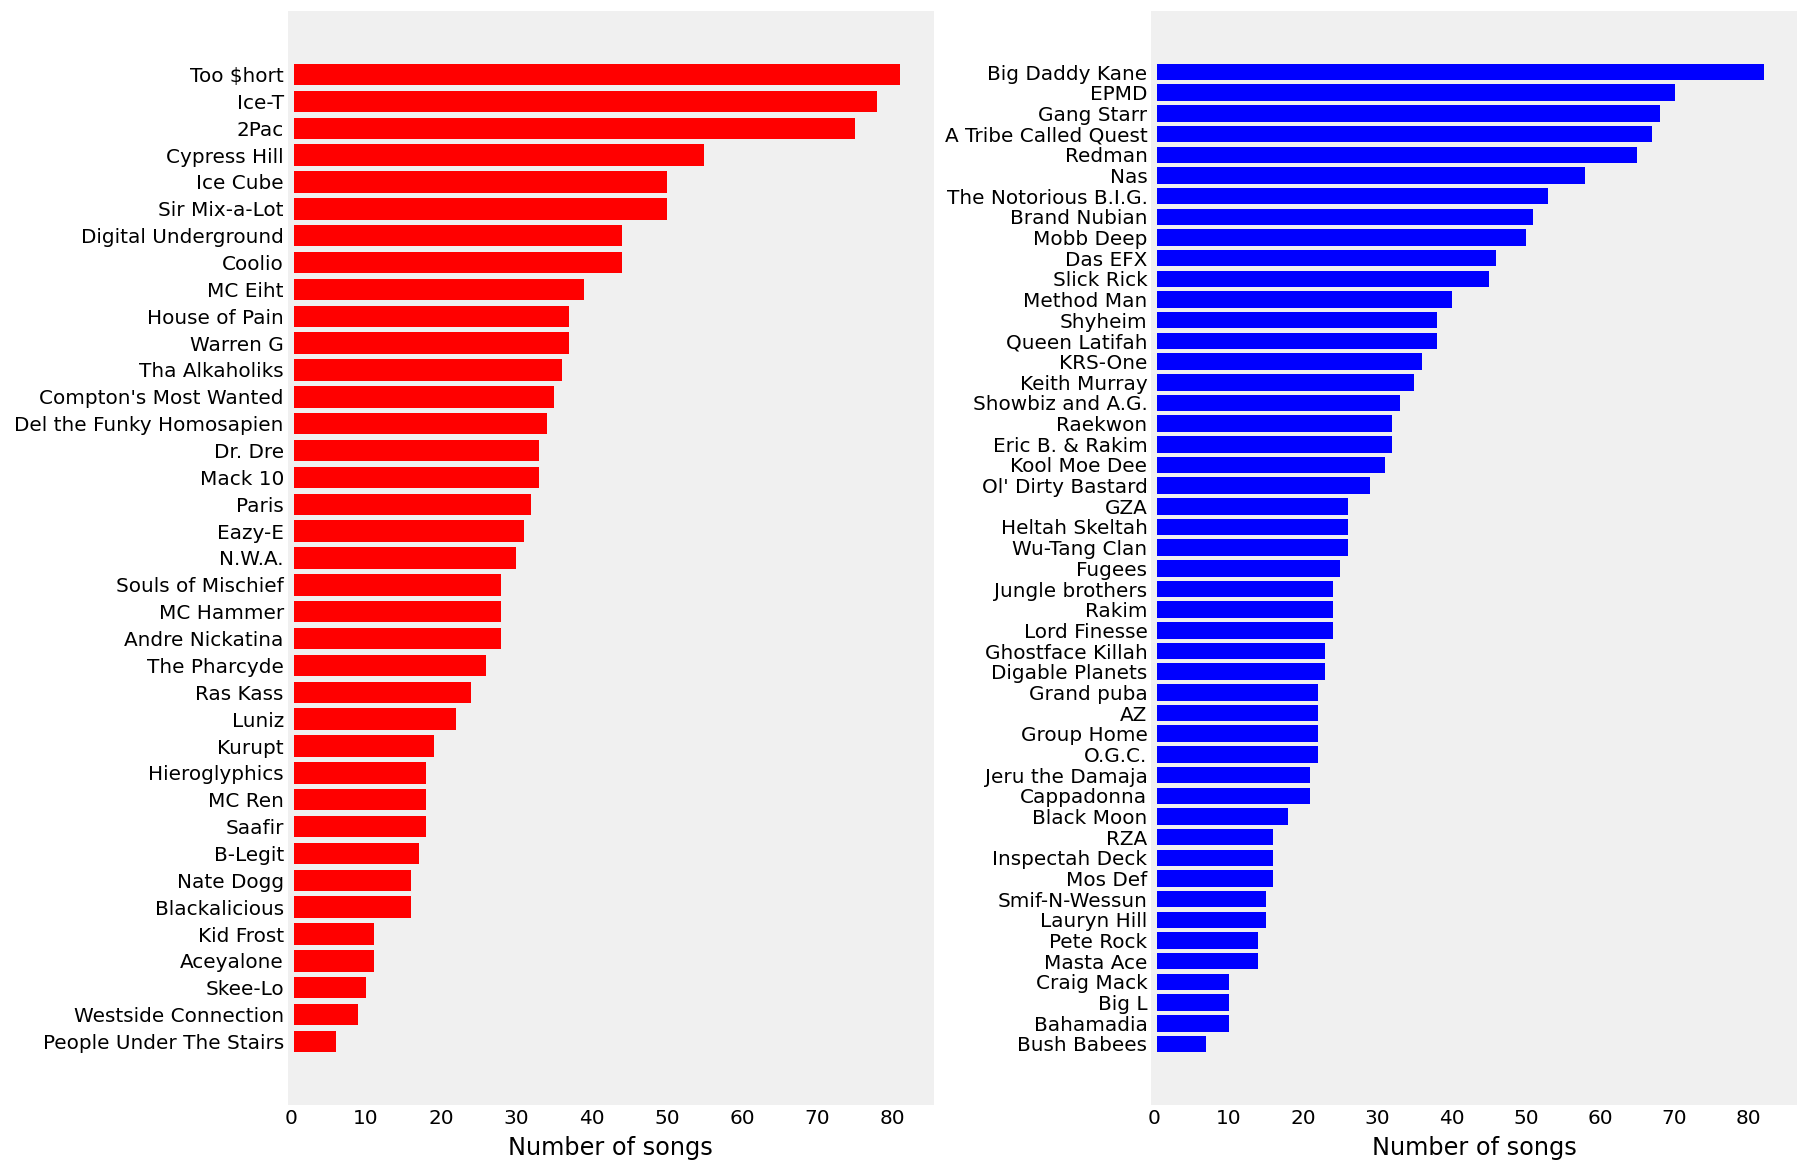

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(12,10))
ax[0].barh(west_eda['artist'], west_eda['lyrics'], color='red')
ax[0].grid(False)
plt.sca(ax[0])
plt.xlabel('Number of songs')
ax[1].barh(east_eda['artist'], east_eda['lyrics'], color='blue')
ax[1].grid(False)
plt.sca(ax[1])
plt.xlabel('Number of songs')
plt.subplots_adjust(wspace=0.35)
fig.savefig('n_songs.png', transparent=True);

Song length:

In [31]:
lyric_count_eda = whole_frame.copy()

# lyrics column now shows the number of words contained in the song lyrics
lyric_count_eda['lyrics'] = lyric_count_eda['lyrics'].apply(lambda x: len(x.split()))

In [32]:
# find the average song length by number of words used for each artist
lyric_count_eda = lyric_count_eda.groupby(['coast', 'artist'], as_index=False)[['lyrics']].mean()
lyric_count_eda.head()

##### this should be used to find odd entries (use without grouping)

,coast,artist,lyrics
0,east,A Tribe Called Quest,617.850746
1,east,AZ,514.136364
2,east,Bahamadia,435.700000
3,east,Big Daddy Kane,595.548780
4,east,Big L,716.800000


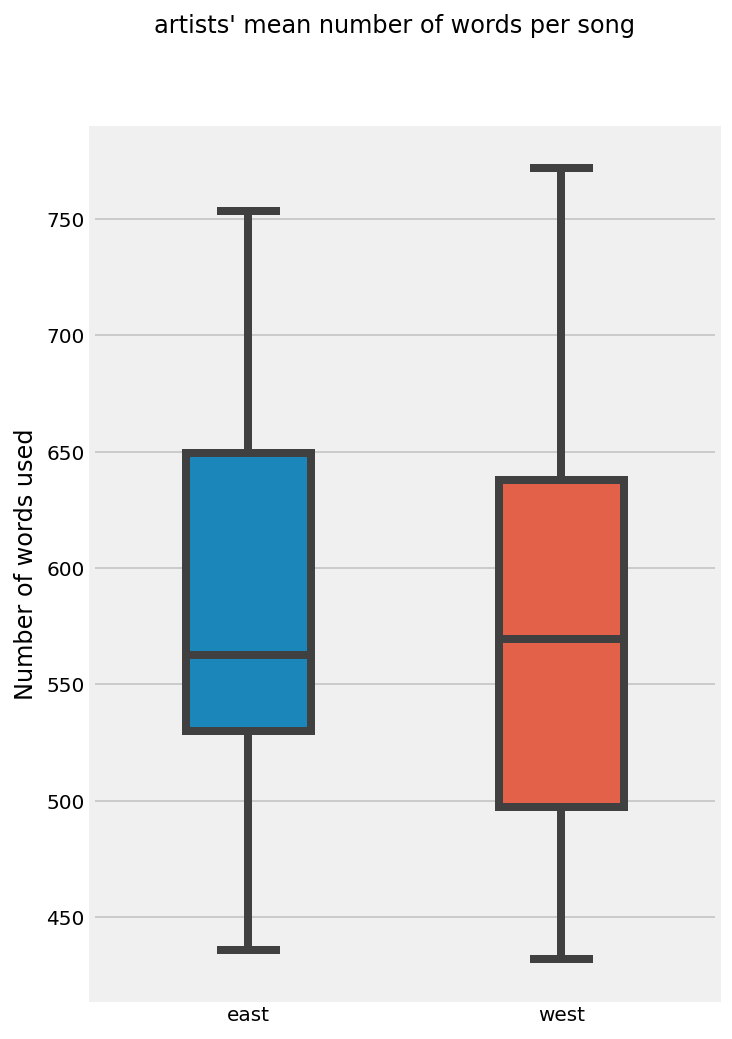

In [48]:
fig,ax = plt.subplots(figsize=(5,8))
sns.boxplot(data=lyric_count_eda, x='coast', y='lyrics', orient='v', width=0.4)
plt.suptitle("artists' mean number of words per song")
plt.ylabel('Number of words used')
plt.xlabel('')
fig.savefig('n_words.png', transparent=True);
# annotate the extreme outliers

More interesting - number of unique words in songs:

In [44]:
unique_lyric_eda = whole_frame.copy()

unique_lyric_eda['lyrics'] = unique_lyric_eda['lyrics'].apply(lambda x: len(set(x.split()))/len(x.split()))
# len(set(x.split())) --- number of unique words used in the song
# divide by len(x.split()) --- total number of words in the song.
# Normalize to get a sense of repetitive the rapper is in their lyric writing / how wide their vocabulary is

In [45]:
unique_lyric_eda = unique_lyric_eda.groupby(['coast', 'artist'], as_index=False)[['lyrics']].mean()
unique_lyric_eda.head()

,coast,artist,lyrics
0,east,A Tribe Called Quest,0.440844
1,east,AZ,0.564551
2,east,Bahamadia,0.561781
3,east,Big Daddy Kane,0.489292
4,east,Big L,0.446270


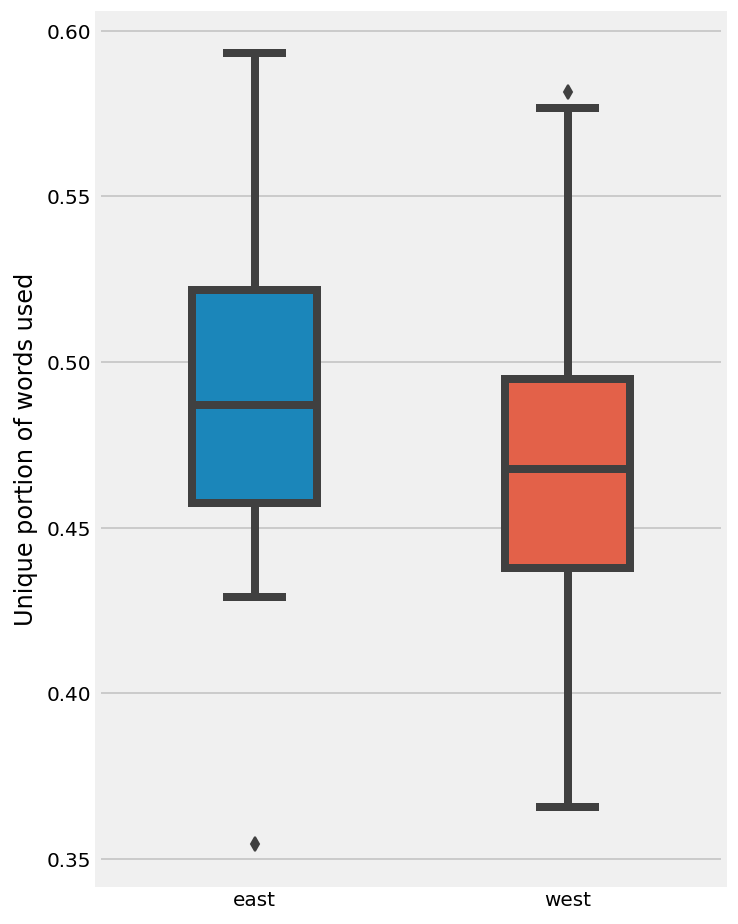

In [47]:
fig,ax=plt.subplots(figsize=(5,8))
sns.boxplot(data=unique_lyric_eda, x='coast', y='lyrics', orient='v', width=0.4)
plt.xlabel("")
plt.ylabel('Unique portion of words used')
fig.savefig('n_unique_words.png', transparent=True);
# annotate the extreme outliers

***BY COAST:***

*Basic word count (should do something on this as part of EDA):*

In [ ]:
### this should be coming from the same dataframe, stop jumping about.

In [56]:
lyrics_east_list = list(whole_frame[whole_frame.coast == 'east'].lyrics)
lyrics_west_list = list(whole_frame[whole_frame.coast == 'west'].lyrics)

In [94]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(lyrics_east_list)
words = cvec.get_feature_names()
cvec_mat_east = cvec.transform(lyrics_east_list)

In [95]:
a = cvec_mat_east.sum(axis=0)
pd.DataFrame(a, columns=words).transpose().sort_values(by=0, ascending=False)[:20].T

,like,im,got,know,dont,yo,cause,niggas,shit,just,man,aint,yeah,make,time,ya,nigga,come,thats,em
0,8830,7290,4594,3966,3961,3612,3562,3166,2960,2858,2763,2245,2229,2182,2073,2059,2007,2006,1982,1754


In [59]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(lyrics_west_list)
words = cvec.get_feature_names()
cvec_mat_west = cvec.transform(lyrics_west_list)

In [60]:
b = cvec_mat_west.sum(axis=0)
pd.DataFrame(b, columns=words).transpose().sort_values(by=0, ascending=False)[:20].T

,im,like,got,dont,cause,nigga,know,aint,niggas,shit,just,fuck,ya,thats,man,make,bitch,yo,time,em
0,6835,5874,4373,3987,3392,3176,3103,2813,2774,2695,2592,2198,2196,1840,1807,1761,1751,1661,1608,1572


***BY SONG:***

In [68]:
def get_song_variables(song):

    cvec = CountVectorizer(stop_words='english')
    cvec.fit([song])
    words = cvec.get_feature_names()
    cvec_mat = cvec.transform([song])

    # unique word count (standardised by total word count)
    unique_word_portion = len(words)/len(song.split())

    # average word length:
    average_length = np.mean([len(word) for word in song.split()])


    return [unique_word_portion, average_length]
    

In [96]:
east_vars = [get_song_variables(song) for song in lyrics_east_list]
west_vars = [get_song_variables(song) for song in lyrics_west_list]

In [99]:
e = pd.DataFrame(east_vars, columns=['unique word portion', 'average word length'])
e.insert(0, 'coast', 'east')

w = pd.DataFrame(west_vars, columns=['unique word portion', 'average word length'])
w.insert(0, 'coast', 'west')

song_comp = pd.concat([e,w])
print(len(song_comp))
song_comp.head()

2690


,coast,unique word portion,average word length
0,east,0.392638,4.202454
1,east,0.555133,4.437262
2,east,0.400621,3.951863
3,east,0.408859,4.229983
4,east,0.509690,4.439922


In [ ]:
### boxplot...

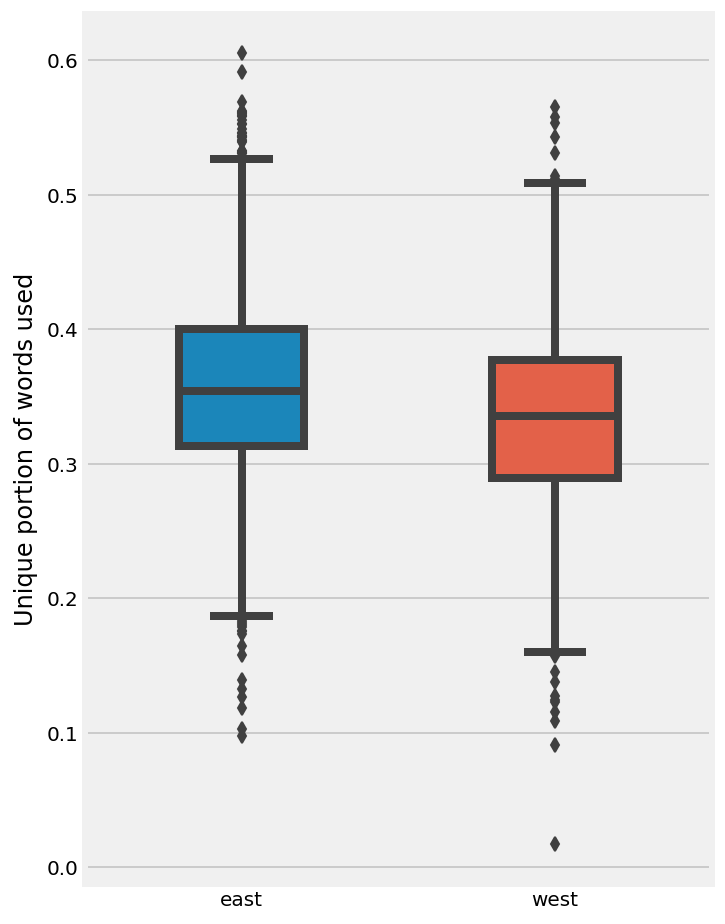

In [100]:
fig,ax=plt.subplots(figsize=(5,8))
sns.boxplot(data=song_comp, x='coast', y='unique word portion', orient='v', width=0.4)
plt.xlabel("")
plt.ylabel('Unique portion of words used')
fig.savefig('n_unique_words.png', transparent=True);

### this looks different to the similar boxplot earlier because it's now including every single song rather than 
# averaging for each rapper. Why am i putting it in there? Which is the more useful one?

### this has to be used to find some dodgy entries.

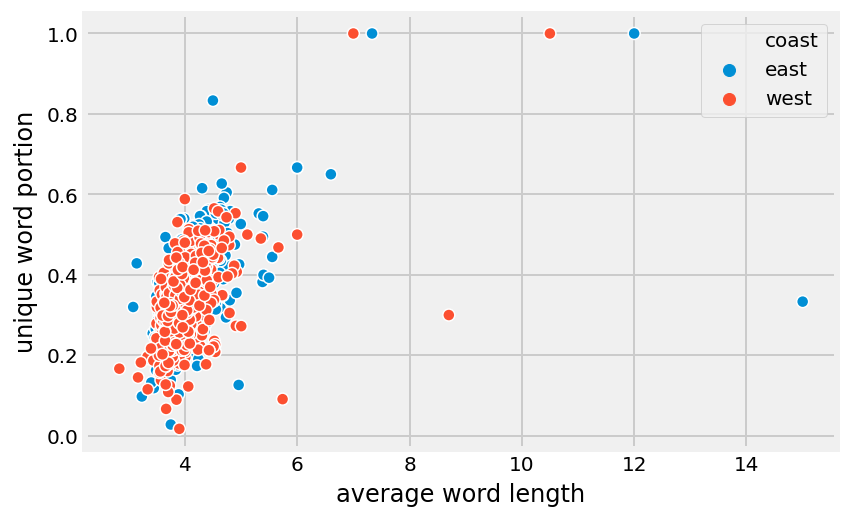

In [22]:
sns.scatterplot(x='average word length', y='unique word portion', hue='coast', data=song_comp)
# again, this is more of a general explore for the sake of it, it's not really proper EDA, it's data analysis on 
# a different question to the one you're claiming. Maybe this kind of meta-analysis could help with the modelling,
# but I don't include it, so you've gotta explain why this stuff is in here.

# this allowed investigating the extreme outliers according to this metric - and dropping the dodgy entries.

In [112]:
song_comp.sort_values('average word length', ascending=False)
# doing some investigation into the outliers - maybe they're dodgy entries.

,coast,unique word portion,average word length
859,west,0.090909,5.740260
670,west,0.468085,5.666121
1293,east,0.545872,5.394495
47,east,0.494845,5.391753
350,east,0.382222,5.382222
...,...,...,...
954,west,0.115324,3.338073
659,west,0.196388,3.334086
510,east,0.097484,3.234277
952,west,0.182081,3.216763


***BY ARTIST:***

*This stuff has already largely been done. Sort that out.*

In [73]:
east_lyrics_frame = whole_frame[whole_frame.coast == 'east']
west_lyrics_frame = whole_frame[whole_frame.coast == 'west']

In [78]:
east_songs = ' '.join(list(east_lyrics_frame.lyrics))
west_songs = ' '.join(list(west_lyrics_frame.lyrics))

all_songs = ' '.join([east_songs, west_songs])

In [79]:
east_lengths = [len(word) for word in east_songs.split()]
west_lengths = [len(word) for word in west_songs.split()]
all_lengths = [len(word) for word in all_songs.split()]

In [80]:
print('average word length - east: ', np.mean(east_lengths))
print('average word length - west: ', np.mean(west_lengths))
print('average word length - all: ', np.mean(all_lengths))

# need to use statistics here to test for equivalence...

average word length - east:  4.001418720325571
average word length - west:  3.940282273540295
average word length - all:  3.9746181903603977


In [102]:
def get_artist_variables(artist, dataframe):
    
    songs = dataframe[dataframe.artist == artist].lyrics
    if len(songs) != 0:

        songs = ' '.join(song for song in songs)

        cvec = CountVectorizer(stop_words='english')
        cvec.fit([songs])
        words = cvec.get_feature_names()
        cvec_mat = cvec.transform([songs])

        # unique word count (standardised by total word count)
        unique_word_portion = len(words)/len(songs)

        # average word length:
        average_length = np.mean([len(word) for word in songs.split()])


        return [unique_word_portion, average_length]
    
    else:
        
        print('drop ', artist)
        return np.nan
    

In [106]:
east_artist_variables = [get_artist_variables(artist, east_lyrics_frame) for artist in set(east_lyrics_frame.artist)]

In [107]:
index = set(east_lyrics_frame.artist)

vis_east = pd.DataFrame(east_artist_variables, 
             index=index,
            columns=['fraction of unique words', 'average word length'])

In [108]:
west_artist_variables = [get_artist_variables(artist, west_lyrics_frame) for artist in set(west_lyrics_frame.artist)]

In [109]:
index = set(west_lyrics_frame.artist)

vis_west = pd.DataFrame(west_artist_variables, 
             index=index,
            columns=['fraction of unique words', 'average word length'])

***visualisation***

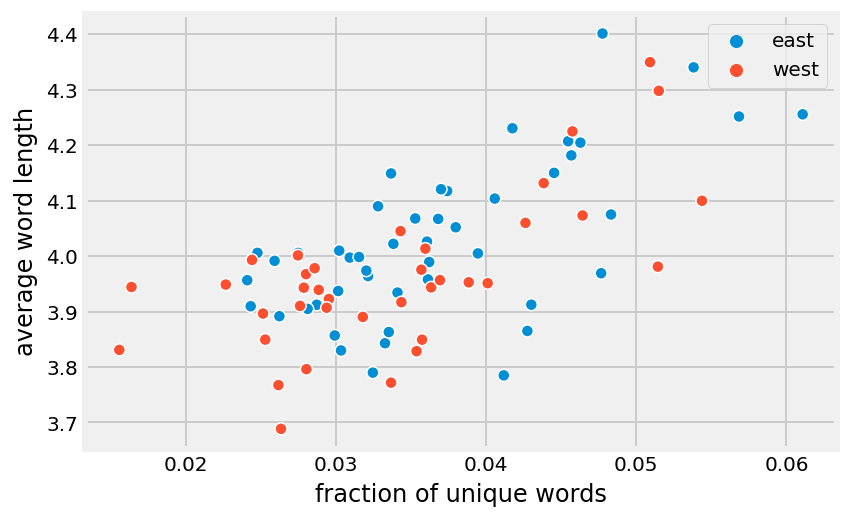

east coast means:
fraction of unique words:  0.03661310521278462
average word length:  4.023067143289

west coast means:
fraction of unique words:  0.03387352069668291
average word length:  3.9619776069662147


4.001418720325571

In [110]:
x = 'fraction of unique words'
y = 'average word length'

X = (list(vis_east[x].values) + list(vis_west[x].values))
Y = list(vis_east[y].values) + list(vis_west[y].values)
coast = ['east']*len(vis_east) + ['west']*len(vis_west)

fig, ax = plt.subplots()
sns.scatterplot(x=X, y=Y, hue=coast)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

print('east coast means:')
print(f'{x}: ', vis_east[x].mean())
print(f'{y}: ', vis_east[y].mean())
print()
print('west coast means:')
print(f'{x}: ', vis_west[x].mean())
print(f'{y}: ', vis_west[y].mean())
np.mean(east_lengths)
# makes sense that these two should be positively correlated - good.
# Not an immediately obvious distinction between the two populations in terms of these two metrics.

# Again, not too relevant really. But useful for dropping some. And general data analysis if the question is simply
# to explore the lyrics of the two coasts, find what the differences may be

In [340]:
def word_rate_plotter(artist, dataframe, word):
    
    songs = dataframe[artist].dropna()
    if len(songs) != 0:

        songs = ' '.join(song for song in songs)

        cvec = CountVectorizer(stop_words='english')
        cvec.fit([songs])
        words = cvec.get_feature_names()
        cvec_mat = cvec.transform([songs])

        # word count:
        a = cvec_mat.sum(axis=0)
        
        try:
            return pd.DataFrame(a, columns=words)[word][0]/len(songs.split())
        except:
            return 0
            
    
    else:
        
        print('drop ', artist)
        return np.nan
    

drop  Pete Rock & C.L. Smooth
drop  Pete Rock & C.L. Smooth


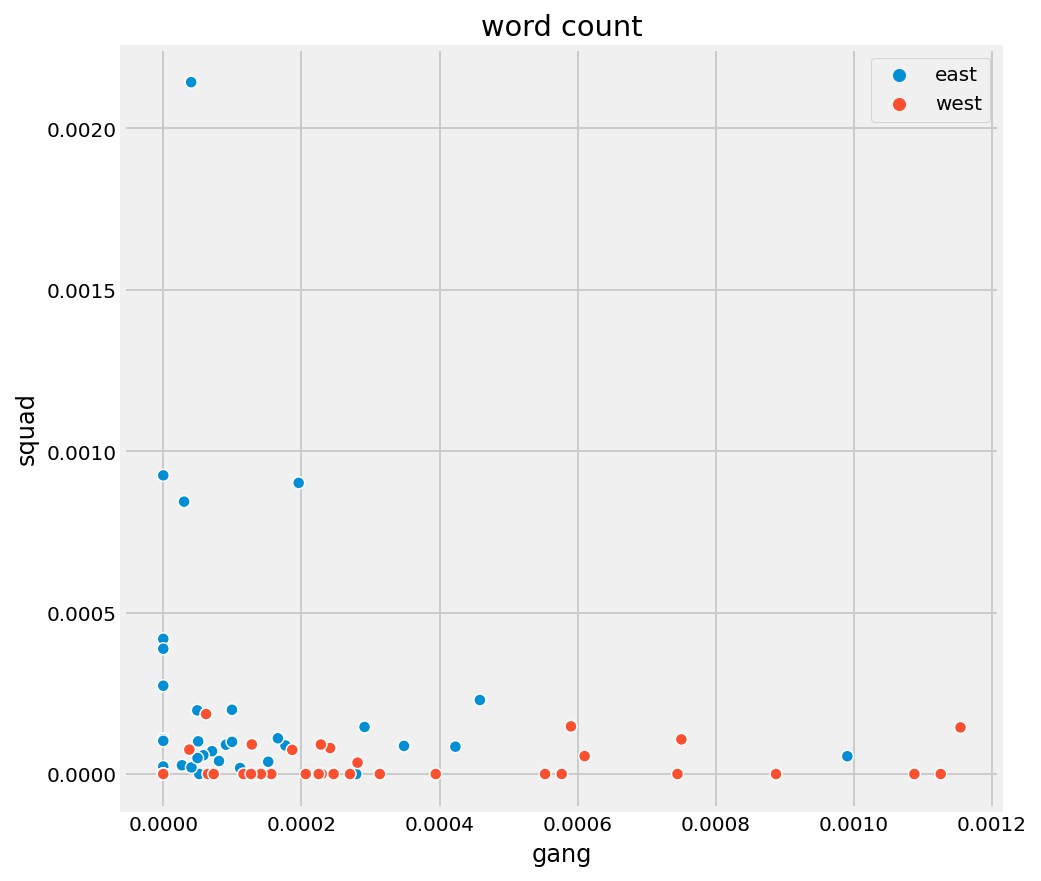

highest use of "gang" on east coast: Gang Starr
highest use of "squad" on east coast: Pete Rock & C.L. Smooth
highest use of "gang" on west coast: Nate Dogg
highest use of "squad" on west coast: Ras Kass


In [342]:
word1 = 'gang'
word2 = 'squad'

X_west = [word_rate_plotter(artist, west_lyrics_frame, word1) for artist in west_lyrics_frame.columns]
Y_west = [word_rate_plotter(artist, west_lyrics_frame, word2) for artist in west_lyrics_frame.columns]

X_east = [word_rate_plotter(artist, east_lyrics_frame, word1) for artist in east_lyrics_frame.columns]
Y_east = [word_rate_plotter(artist, east_lyrics_frame, word2) for artist in east_lyrics_frame.columns]

X_east.remove(np.nan)
Y_east.remove(np.nan)

X = X_east + X_west
Y = Y_east + Y_west

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=X, y=Y, hue=coast)
ax.set_title('word count')
ax.set_xlabel(word1)
ax.set_ylabel(word2)
plt.show()

print(f'highest use of "{word1}" on east coast: {east_lyrics_frame.columns[np.array(X_east).argmax()]}')
print(f'highest use of "{word2}" on east coast: {east_lyrics_frame.columns[np.array(Y_east).argmax()]}')
print(f'highest use of "{word1}" on west coast: {west_lyrics_frame.columns[np.array(X_west).argmax()]}')
print(f'highest use of "{word2}" on west coast: {west_lyrics_frame.columns[np.array(Y_west).argmax()]}')

***WORDCLOUD***

In [115]:
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count


def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True) #what's the itemgetter doing?
    return sort_result

In [116]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(lyrics_west_list)
words = cvec.get_feature_names()
cvec_mat_west = cvec.transform(lyrics_west_list)

df_word_frequency = {}
csum_west = word_counter(cvec_mat_west)

df_word_frequency = pd.DataFrame(word_frequency_sorter(
        words, csum_west), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)

In [117]:
df_word_frequency.head()

,frequency
word,
im,6835
like,5874
got,4373
dont,3987
cause,3392


In [118]:
words = list(df_word_frequency.index)[:100]
frequencies = list(df_word_frequency.frequency)[:100]

In [119]:
def to_wordcloud(word_frequency_matrix, n_words):
    
    words = list(word_frequency_matrix.index)[:n_words]
    frequencies = list(word_frequency_matrix.frequency)[:n_words]

    
    return {word:freq for word,freq in zip(words, frequencies)}

In [120]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(98, 100)

In [121]:
pic = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery/4656.jpg',stream=True).raw))

inverse_pic = np.array([[[1-k for k in j] for j in i] for i in pic])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', colormap='Pastel1',
                mask = inverse_pic,
                min_font_size = 10).generate_from_frequencies(to_wordcloud(df_word_frequency, 500))

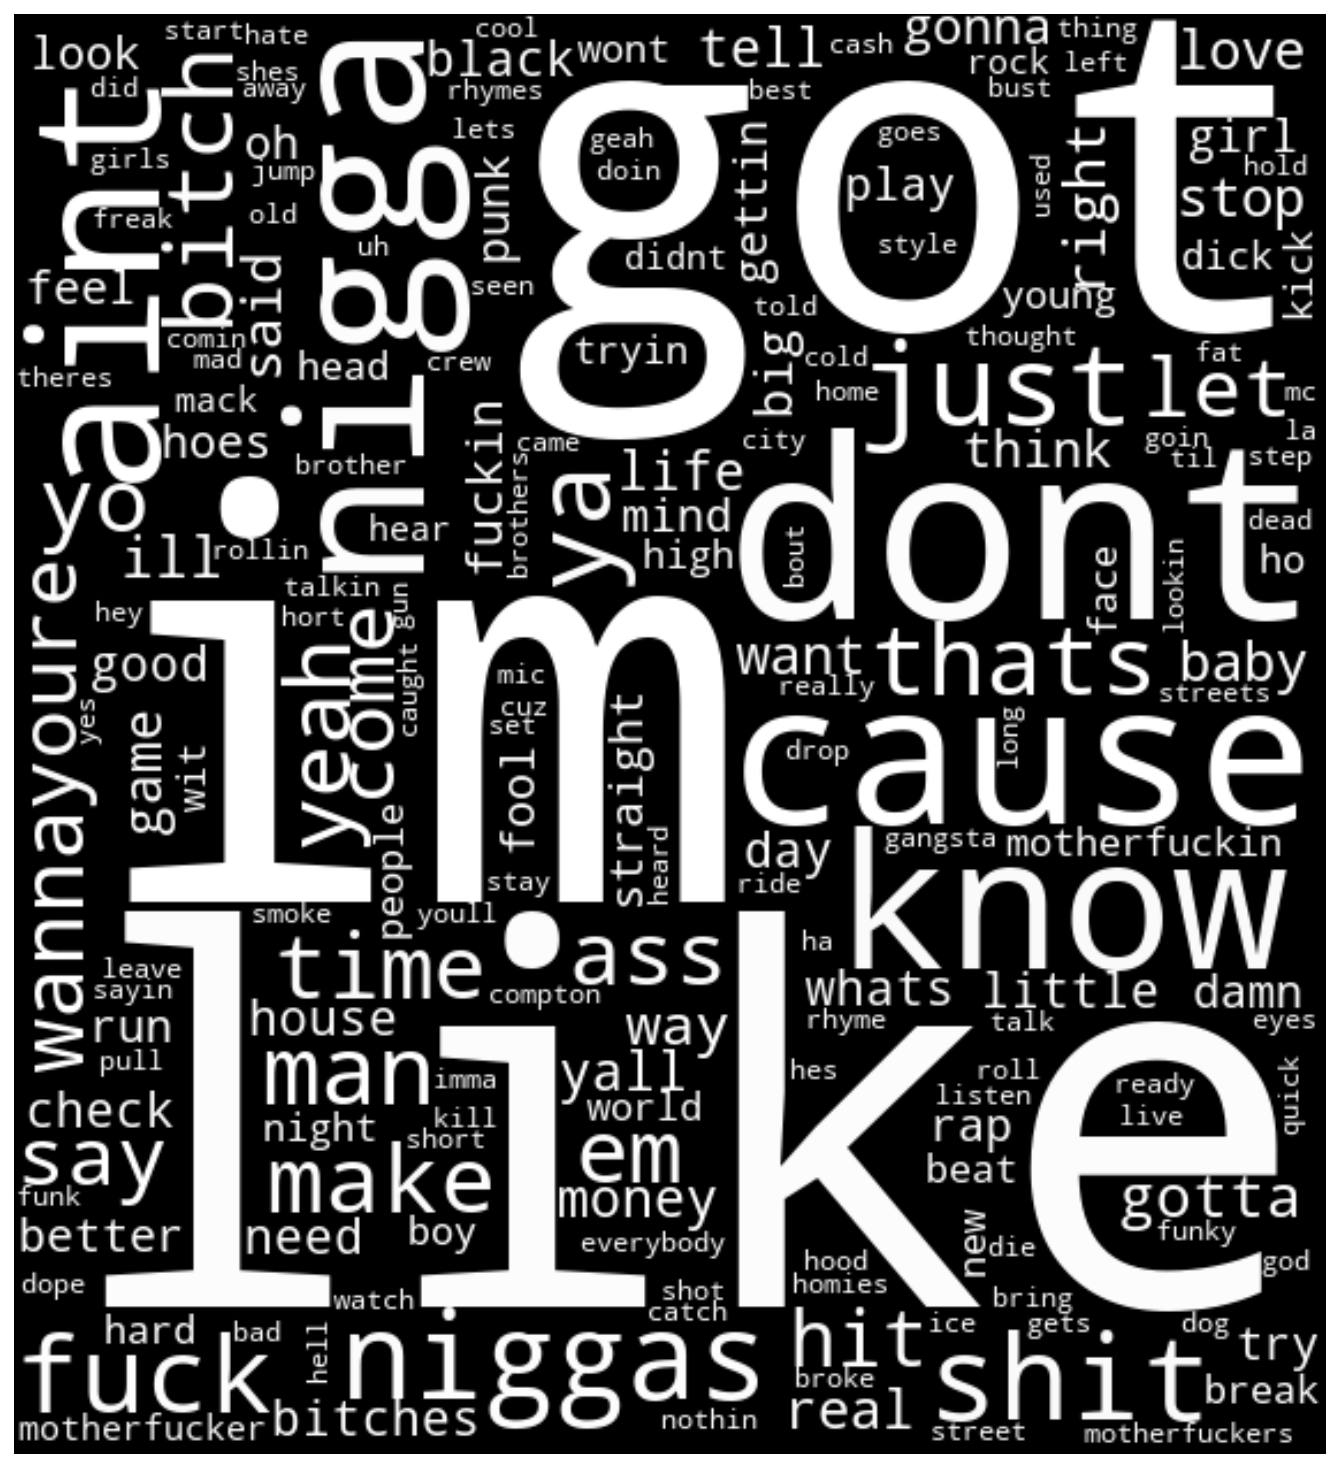

In [122]:
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [ ]:
pic = np.array(Image.open("/Users/georgerolls/Desktop/map.png"))
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                mask = pic,
                min_font_size = 10).generate_from_frequencies(to_wordcloud(df_word_frequency, 500))

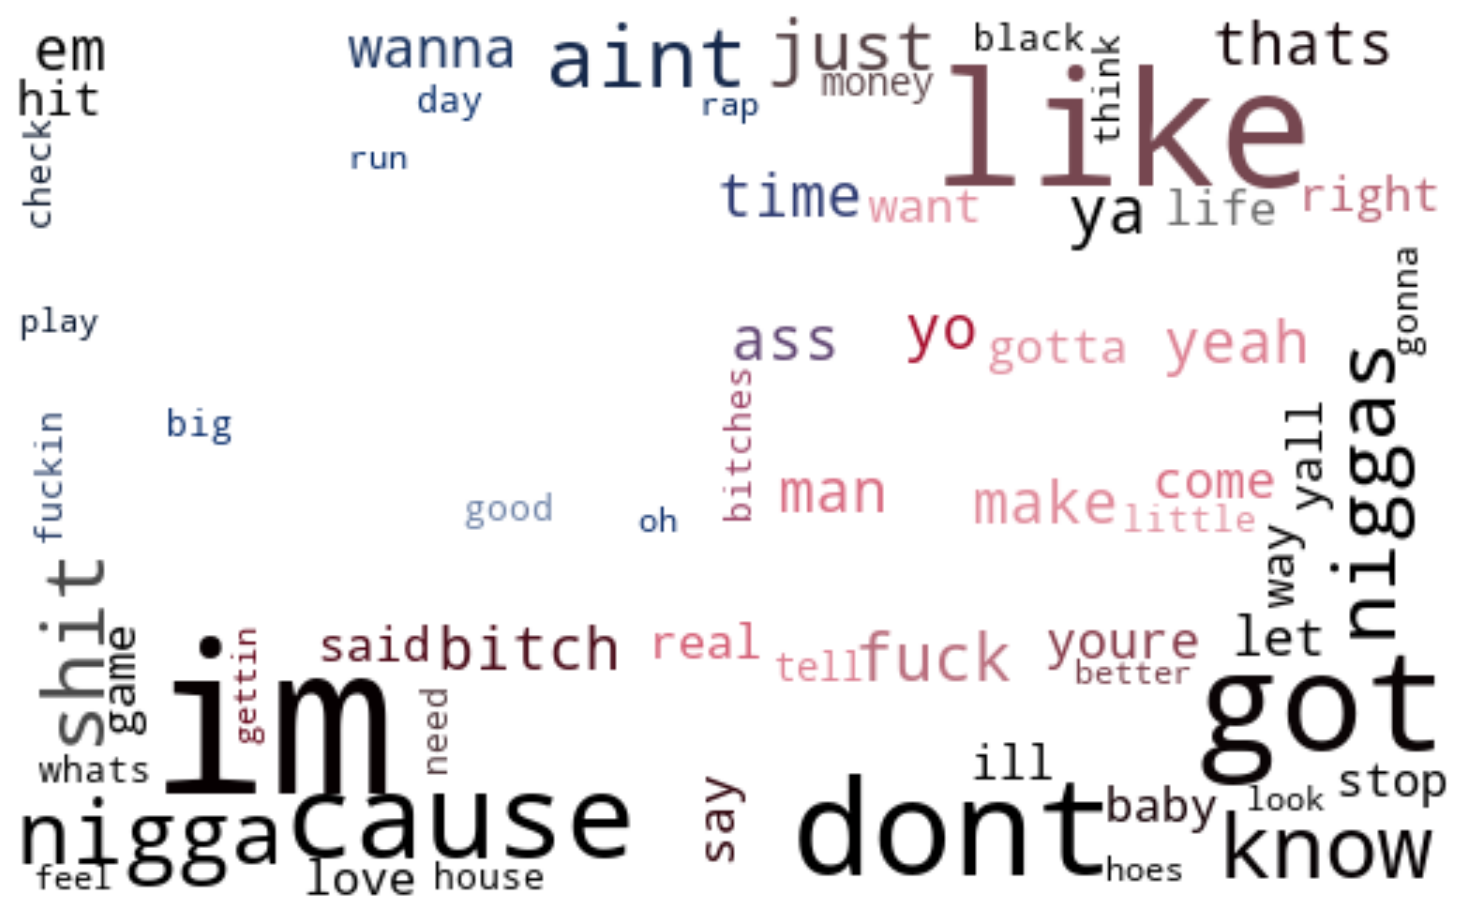

In [207]:
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud.recolor(color_func=image_colors, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()